# PyGIMLi - DCIP

Using the DCIP (Direct Current, Induced Polarization) solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_dcip/pygimli_dcip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Note: This notebook is adapted from a PyGIMLi example: [Naive complex-valued electrical inversion](https://www.pygimli.org/_examples_auto/3_dc_and_ip/plot_07_simple_complex_inversion.html#sphx-glr-examples-auto-3-dc-and-ip-plot-07-simple-complex-inversion-py)

The key difference between ERT and DCIP as implemented in PyGIMLi is that for DCIP resistivties are expressed as complex numbers with the real part representing the resistivtiy and the imaginary part representing the chargeability. This means that entries into the model vector and the data vector are complex numbers. While `numpy.linalg.solve` is able to call the appropriate lapack subroutine for a complex linear system other solvers typically expect the model vector and data vector to be real. This means that the following transformation needs to be accounted for in the user provided functions for the objective function, Hessian and gradient for CoFI.

The linear equation $ A x =b $ with the elements of $A$, $b$ and $x$ being complex numbers can be rewritten using real numbers as follows

$$\begin{pmatrix}A^r & -A^c \\A^c & A^r \end{pmatrix}
\begin{pmatrix}
x^r \\
x^c 
\end{pmatrix}
=
\begin{pmatrix}
b^r \\
b^c 
\end{pmatrix},$$

with $b=( b_1^r+b_1^c i, b_2^r+b_2^c i,...,b_n^r+b_n^c i)$ being rewritten as $(b^r,b^c)$ with $b^r=(b_1^r,b_2^r,...,b_n^r)$ and $b^c=(b_1^c,b_2^c,...,b_n^c)$ and analogus reordering for $A$ and $x$.  

See https://ijpam.eu/contents/2012-76-1/11/11.pdf for more details.



## 1. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli
import cofi

np.random.seed(42)

Below we define a set of utility functions that help define the problem, generating data and making plots. Feel free to skip reading the details of these utility functions and come back later if you want.

### 1.1. Helper functions for complex numbers

In [3]:
def rho_phi_to_complex(rho, phi):      # rho * e^(phi * i)
    return pygimli.utils.toComplex(rho, phi)

def rho_phi_from_complex(complx):      # |complx|, arctan(complx.imag, complx.real)
    return np.abs(complx), np.arctan2(complx.imag, complx.real)

def complex_to_real(complx):           # complx vector of size n -> size 2n
    return pygimli.utils.squeezeComplex(complx)

def complex_from_real(real):           # real vector of size n -> size n/2
    return pygimli.utils.toComplex(real)

### 1.2. Helper functions for PyGIMLi modelling

In [4]:
# Utility Functions
x_inv_start = -2
x_inv_stop = 52
y_inv_start = -20
y_inv_stop = 0

def survey_scheme(start=0, stop=50, num=51, schemeName="dd"):
    scheme = pygimli.physics.ert.createData(elecs=np.linspace(start=start, stop=stop, num=num),schemeName=schemeName)
    return scheme

def model_true(
    scheme, 
    start=[-55, 0], 
    end=[105, -80], 
    anomalies_pos=[[10,-7],[40,-7]], 
    anomalies_rad=[5,5],
    rhomap=[[1, rho_phi_to_complex(100, 0 / 1000)],
          # Magnitude: 50 ohm m, Phase: -50 mrad
          [2, rho_phi_to_complex(50, 0 / 1000)],
          [3, rho_phi_to_complex(100, -50 / 1000)],]
    ):
    world = pygimli.meshtools.createWorld(start=start, end=end, worldMarker=True)
    for s in scheme.sensors():          # local refinement 
        world.createNode(s + [0.0, -0.1])
    geom = world
    for i, (pos, rad) in enumerate(zip(anomalies_pos, anomalies_rad)):
        anomaly = pygimli.meshtools.createCircle(pos=pos, radius=rad, marker=i+2)
        geom += anomaly
    mesh = pygimli.meshtools.createMesh(geom, quality=33)
    return mesh, rhomap

def ert_simulate(mesh, scheme, rhomap, noise_level=1, noise_abs=1e-6):
    pg_data = pygimli.physics.ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=noise_level,
                        noise_abs=noise_abs, seed=42)
    data_complex = rho_phi_to_complex(pg_data["rhoa"].array(), pg_data["phia"].array())
    data_log_complex = np.log(data_complex)
    # generate data covariance matrix inverse
    dc_err = pg_data["err"]
    ip_err = pg_data["iperr"]
    m_err = rho_phi_to_complex(1/dc_err, 1/ip_err)
    Wd = np.diag(m_err)
    Cd_inv = Wd.conj().dot(Wd)
    return pg_data, data_complex, data_log_complex, Cd_inv

def ert_manager(pg_data, verbose=False):
    return pygimli.physics.ert.ERTManager(pg_data, verbose=verbose, useBert=True)

def inversion_mesh(ert_mgr):
    inv_mesh = ert_mgr.createMesh(ert_mgr.data)
    # print("model size", inv_mesh.cellCount())   # 1031
    ert_mgr.setMesh(inv_mesh)
    return inv_mesh

def ert_forward_operator(ert_mgr, pg_data, inv_mesh):
    forward_oprt = ert_mgr.fop
    forward_oprt.setComplex(True)
    forward_oprt.setData(pg_data)
    forward_oprt.setMesh(inv_mesh, ignoreRegionManager=True)
    return forward_oprt

def reg_matrix(forward_oprt):
    region_manager = forward_oprt.regionManager()
    region_manager.setConstraintType(2)
    Wm = pygimli.matrix.SparseMapMatrix()
    region_manager.fillConstraints(Wm)
    Wm = pygimli.utils.sparseMatrix2coo(Wm)
    return Wm

def starting_model(data, inv_mesh, rho_val=None, phi_val=None):
    rho_start = np.median(data["rhoa"]) if rho_val is None else rho_val
    phi_start = np.median(data["phia"]) if phi_val is None else phi_val
    start_model_val = rho_phi_to_complex(rho_start, phi_start)
    start_model_complex = np.ones(inv_mesh.cellCount()) * start_model_val
    start_model_log_complex = np.log(start_model_complex)
    start_model_log_real = complex_to_real(start_model_log_complex)
    return start_model_complex, start_model_log_complex, start_model_log_real

def model_vector(rhomap, mesh):
    return pygimli.solver.parseArgToArray(rhomap, mesh.cellCount(), mesh).array()

### 1.3. Helper functions for plotting

In [5]:
def plot_model(mesh, model_complex, title):
    rho, phi = rho_phi_from_complex(model_complex)
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    pygimli.show(mesh, data=rho, label=r"$\Omega m$", ax=axes[0])
    axes[0].set_xlim(x_inv_start, x_inv_stop)
    axes[0].set_ylim(y_inv_start, y_inv_stop)
    axes[0].set_title("Resistivity")
    pygimli.show(mesh, data=phi * 1000, label=r"mrad", ax=axes[1])
    axes[1].set_xlim(x_inv_start, x_inv_stop)
    axes[1].set_ylim(y_inv_start, y_inv_stop)
    axes[1].set_title("Chargeability")
    fig.suptitle(title)

def plot_data(pg_data, data_complex, title):
    rho, phi = rho_phi_from_complex(data_complex)
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    pygimli.physics.ert.showERTData(pg_data, vals=rho, label=r"$\Omega$m", ax=axes[0])
    axes[0].set_title("Apparent Resistivity")
    pygimli.physics.ert.showERTData(pg_data, vals=phi*1000, label=r"mrad", ax=axes[1])
    axes[1].set_title("Apparent Chargeability")
    fig.suptitle(title)

## 2. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

### 2.1. True model

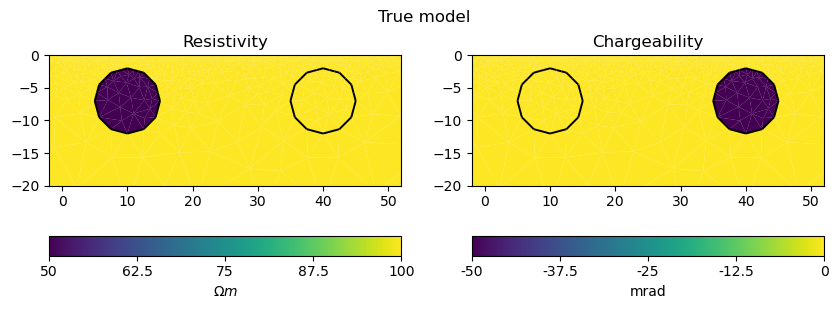

In [6]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
plot_model(mesh, model_vector(rhomap, mesh), "True model")

### 2.2. Generate synthetic data

Generate the synthetic data as a container with all the necessary information for plotting:

21/11/22 - 09:56:10 - pyGIMLi - INFO - Complex resistivity values found.
21/11/22 - 09:56:10 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.013 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)
Calculating response for model: min = (50,0) max = (100,0)
Allocating memory for primary potential...... 0.003

No primary potential for secondary field calculation. Calculating analytically...
Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix 

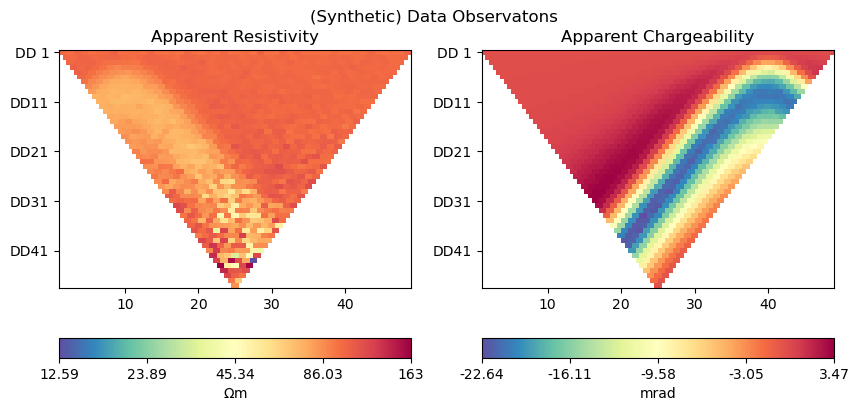

In [7]:
pg_data, data_complex, data_log_complex, Cd_inv = ert_simulate(mesh, scheme, rhomap)

plot_data(pg_data, data_complex, "(Synthetic) Data Observatons")

### 2.3. ERTManager

Further, we create a `pygimli.ert.ERTManager` instance to keep record of problem-specific
information like the inversion mesh, and to perform forward operation for the inversion
solvers.

In [8]:
# create PyGIMLi's ERT manager
ert_mgr = ert_manager(pg_data)

### 2.4. Inversion mesh

The inversion can use a different mesh and the mesh to be used should know nothing about the  mesh that was designed based on the true model. Here we first use a triangular mesh for the inversion, which makes the problem underdetermined.

21/11/22 - 09:56:11 - pyGIMLi - INFO - Found 2 regions.
21/11/22 - 09:56:11 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

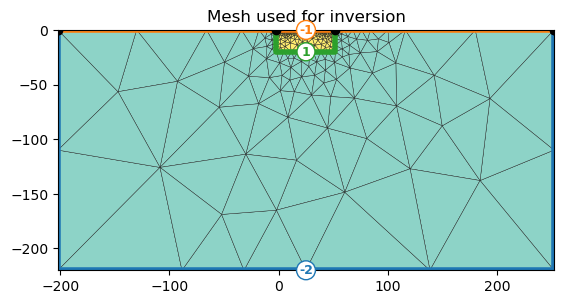

In [9]:
inv_mesh = inversion_mesh(ert_mgr)

ax = pygimli.show(inv_mesh, showMesh=True, markers=True, colorBar=False)
ax[0].set_title("Mesh used for inversion")

### 2.5. Forward operator, regularization matrix

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularization using PyGIMLi.

Our model will be in log space when we perform inversion (for numerical stability purposes).

21/11/22 - 09:56:12 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
21/11/22 - 09:56:12 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
21/11/22 - 09:56:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/11/22 - 09:56:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


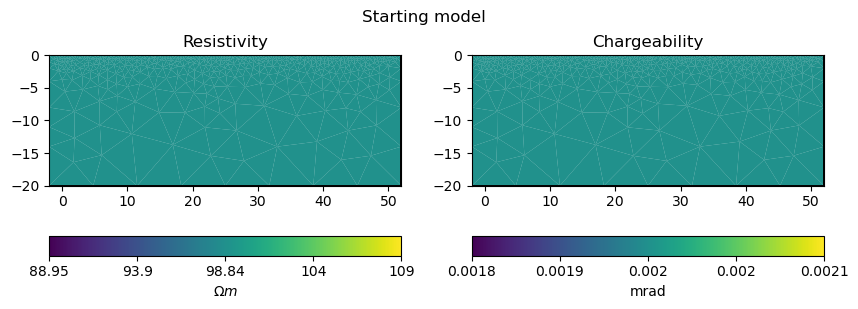

In [10]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_mgr, scheme, inv_mesh)

# extract regularization matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model, start_model_log, start_model_log_real = starting_model(pg_data, ert_mgr.paraDomain)
plot_model(ert_mgr.paraDomain, start_model, "Starting model")

### 2.6. Utility functions to pass to CoFI

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined below as additional utility functions, so feel free to read them into details if you want to understand more. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_data_misfit`
- `get_regularization`
- `get_gradient`
- `get_hessian`

In [11]:
# Utility Functions (additional)

def _ensure_numpy(model):
    if "torch.Tensor" in str(type(model)):
        model = model.cpu().detach().numpy()
    return model

# model_log_complex -> data_log_complex
def get_response(model_log_complex, fop):
    model_complex = np.exp(model_log_complex)
    model_real = complex_to_real(model_complex)
    model_real = _ensure_numpy(model_real)
    data_real = np.array(fop.response(model_real))
    data_complex = complex_from_real(data_real)
    data_log_complex = np.log(data_complex)
    return data_log_complex

# model_log_complex -> J_log_log_complex
def get_jacobian(model_log_complex, fop):
    model_complex = np.exp(model_log_complex)
    model_real = complex_to_real(model_complex)
    model_real = _ensure_numpy(model_real)
    J_block = fop.createJacobian(model_real)
    J_real = np.array(J_block.mat(0))
    J_imag = np.array(J_block.mat(1))
    J_complex = J_real + 1j * J_imag
    data_log_complex = get_response(model_log_complex, fop)
    data_complex = np.exp(data_log_complex)
    J_log_log_complex = J_complex / data_complex[:,np.newaxis] * model_complex[np.newaxis,:]
    return J_log_log_complex

# model_log_complex -> res_data_log_complex
def get_residuals(model_log_complex, data_log_complex, fop):
    synth_data_log_complex = get_response(model_log_complex, fop)
    return data_log_complex - synth_data_log_complex

# model_log_real -> obj_log_real
def get_objective(model_log_real, data_log_complex, fop, lamda, Wm, Cd_inv):
    # convert model_log_real into complex numbers
    model_log_complex = complex_from_real(model_log_real)
    # calculate data misfit
    res_log_complex = get_residuals(model_log_complex, data_log_complex, fop)
    data_misfit = res_log_complex.conj().dot(Cd_inv).dot(res_log_complex)
    # calculate regularization term
    weighted_model_log_real = Wm.dot(model_log_complex)
    reg = lamda * weighted_model_log_real.conj().dot(weighted_model_log_real)
    # sum up
    print(f"data misfit: {np.abs(data_misfit)}, reg: {np.abs(reg)}")
    result = np.abs(data_misfit + reg)
    return result

# model_log_real -> grad_log_real
def get_gradient(model_log_real, data_log_complex, fop, lamda, Wm, Cd_inv):
    # convert model_log_real into complex numbers
    model_log_complex = complex_from_real(model_log_real)
    # calculate gradient for data misfit
    res = get_residuals(model_log_complex, data_log_complex, fop)
    jac = get_jacobian(model_log_complex, fop)
    data_misfit_grad = - jac.conj().T.dot(Cd_inv).dot(res)
    # calculate gradient for regularization term
    reg_grad = lamda * Wm.T.dot(Wm).dot(model_log_complex)
    # sum up
    grad_complex = data_misfit_grad + reg_grad
    grad_real = complex_to_real(grad_complex)
    return grad_real

# model_log_real -> hess_log_real
def get_hessian(model_log_real, data_log_complex, fop, lamda, Wm, Cd_inv):
    # convert model_log_real into complex numbers
    model_log_complex = complex_from_real(model_log_real)
    # calculate hessian for data misfit
    res = get_residuals(model_log_complex, data_log_complex, fop)
    jac = get_jacobian(model_log_complex, fop)
    data_misfit_hessian = jac.conj().T.dot(Cd_inv).dot(jac)
    # calculate hessian for regularization term
    reg_hessian = lamda * Wm.T.dot(Wm)
    # sum up
    hessian_complex = data_misfit_hessian + reg_hessian
    nparams = len(model_log_complex)
    hessian_real = np.zeros((2*nparams, 2*nparams))
    hessian_real[:nparams,:nparams] = np.real(hessian_complex)
    hessian_real[:nparams,nparams:] = -np.imag(hessian_complex)
    hessian_real[nparams:,:nparams] = np.imag(hessian_complex)
    hessian_real[nparams:,nparams:] = np.real(hessian_complex)
    return hessian_real

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [12]:
# hyperparameters
lamda=500

# CoFI - define BaseProblem
dcip_problem = cofi.BaseProblem()
dcip_problem.name = "DC-IP defined through PyGIMLi"
dcip_problem.set_objective(get_objective, args=[data_log_complex, forward_oprt, lamda, Wm, Cd_inv])
dcip_problem.set_gradient(get_gradient, args=[data_log_complex, forward_oprt, lamda, Wm, Cd_inv])
dcip_problem.set_hessian(get_hessian, args=[data_log_complex, forward_oprt, lamda, Wm, Cd_inv])
dcip_problem.set_initial_model(start_model_log_real)

## 3. Define the inversion options and run

### 3.1. SciPy's optimizer (trust-ncg)

In [13]:
dcip_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimization": [
        "scipy.optimize.minimize",
        "torch.optim"
    ],
    "matrix solvers": [
        "cofi.simple_newton"
    ],
    "sampling": []
}


In [14]:
inv_options_scipy = cofi.InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")

class CallBack:
    def __init__(self):
        self._i = 1
    def __call__(self, x):
        print(f"Iteration #{self._i}, objective value: {dcip_problem.objective(x)}")
        self._i += 1
        
inv_options_scipy.set_params(method="trust-ncg", options={"maxiter":5}, callback=CallBack())

In [15]:
inv_scipy = cofi.Inversion(dcip_problem, inv_options_scipy)
inv_result_scipy = inv_scipy.run()
print(f"\nSolver message: {inv_result_scipy.message}")

data misfit: 34060.41650578423, reg: 5.955899834418639e-25
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
data misfit: 15747.365302065298, reg: 185.946700959808
data misfit: 15747.365302065298, reg: 185.946700959808
Iteration #1, objective value: 15933.312003025107
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src

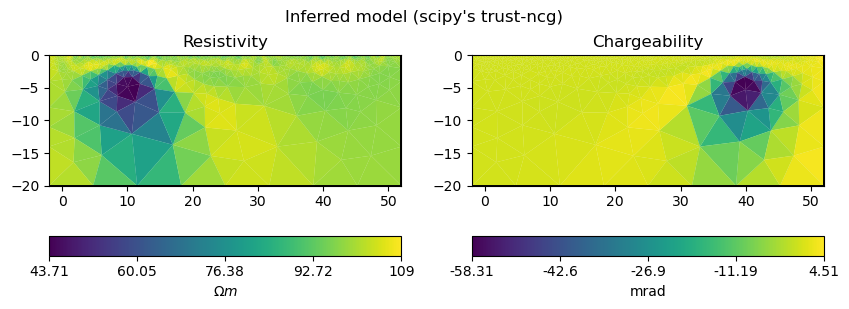

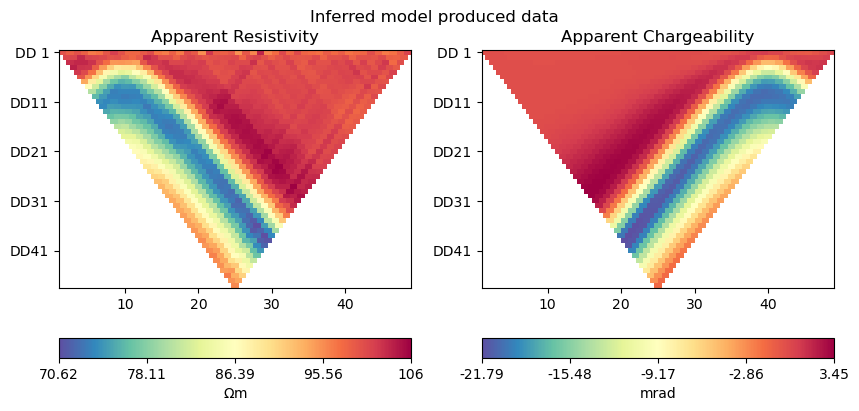

In [16]:
model_scipy = np.exp(complex_from_real(inv_result_scipy.model))
plot_model(ert_mgr.paraDomain, model_scipy, "Inferred model (scipy's trust-ncg)")

synth_data_scipy = np.exp(get_response(np.log(model_scipy), forward_oprt))
plot_data(pg_data, synth_data_scipy, "Inferred model produced data")

### 3.2. PyTorch's optimizer (RAdam)

In [17]:
inv_options_torch = cofi.InversionOptions()
inv_options_torch.set_tool("torch.optim")
inv_options_torch.set_params(algorithm="RAdam", lr=0.0002, num_iterations=20)
# inv_options_torch.set_params(algorithm="Rprop", lr=0.05, num_iterations=20)

In [18]:
inv_torch = cofi.Inversion(dcip_problem, inv_options_torch)
inv_result_torch = inv_torch.run()

*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
data misfit: 34060.41650578423, reg: 5.955899834418639e-25
Iteration #0, objective value: 34060.41650578423
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
data misfit: 12356.31531716759, reg: 1092.6676404707994
Iteration #1, objective value: 13448.982957638389
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
data misfit: 16008.70275316, reg: 1384.906385006527
Iteration #2, objective value: 17393.60913816653
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
data misfit: 10108.529743145074, reg: 1590.7181605618323
Iteration #3, objective value: 11699.247903706906
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424

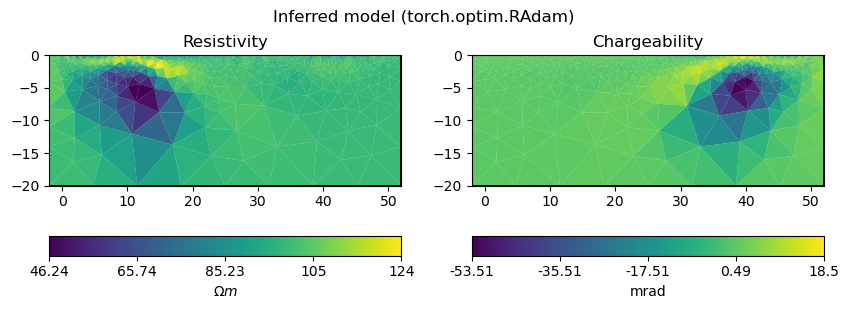

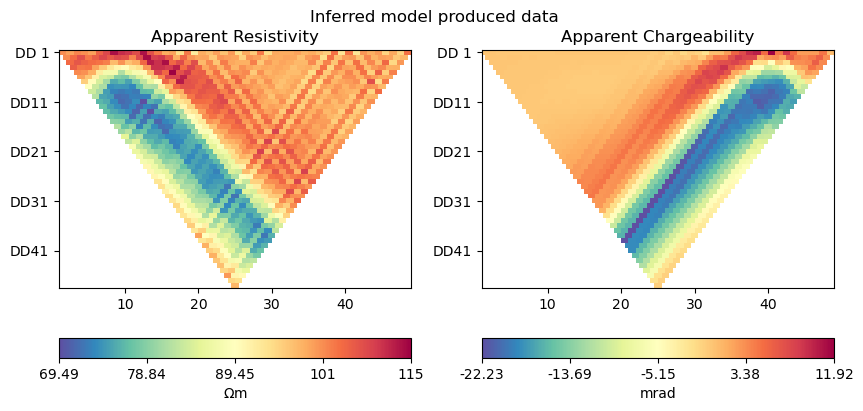

In [19]:
model_torch = np.exp(complex_from_real(inv_result_torch.model))
plot_model(ert_mgr.paraDomain, model_torch, "Inferred model (torch.optim.RAdam)")

synth_data_torch = np.exp(get_response(np.log(model_torch), forward_oprt))
plot_data(pg_data, synth_data_torch, "Inferred model produced data")

---
## Watermark

In [20]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "torch", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev21
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
torch 1.12.1+cu102
matplotlib 3.5.3
